Homework 2

Hurum Maksora Tohfa

#### Problem 1

$$
\textrm{Overlap area}= \begin{cases}\pi r_2^2 & a \leq r_1-r_2 \\ 0 & a \geq r_1+r_2 \\ 2\left(\frac{1}{2} \theta_1 r_1^2 +\frac{1}{2} \theta_2 r_2^2- \sqrt{s(s-a)\left(s-r_1\right)\left(s-r_2\right)} \right) & \text { else }\end{cases}
$$
where $s=\frac{1}{2}(1+k+b)$, $\cos \theta_i=\frac{r_i^2+a^2-r_{3-i}^2}{2 a r_i}$



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import astropy.constants as const

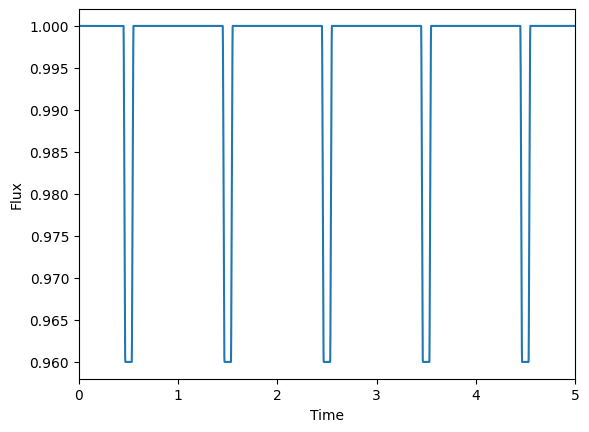

In [2]:
##problem 2

def f_covered(b, k):
    fractions = np.zeros_like(b)
    lower = 1-k
    upper = 1+k
    fractions[b < lower] = k**2
    #there is no overlap
    fractions[b >= upper] = 0

    touching = np.logical_and(b >= lower, b < upper)
    fractions[touching] = _f_covered_transition(b[touching], k)

    return fractions

def _f_covered_transition(b, k):
    theta1 = np.arccos((b**2 + 1 - k**2) / (2 * b))
    theta2 = np.arccos((b**2 + k**2 - 1) / (2 * b * k))

    sec1 = 0.5 * theta1
    sec2 = 0.5 * theta2 * k**2

    s = 0.5 * (1 + b + k)
    triangle = np.sqrt(s * (s - 1) * (s - k) * (s - b))

    return 2 * (sec1 + sec2 - triangle) / np.pi


def lightcurve(t, t0, b0, T, k, P, F0):
    t_fold = t % P
    v = 2 / T * np.sqrt((1 + k)**2 - b0**2)
    b = np.sqrt(b0**2 + (v * (t_fold - t0))**2)
    return F0 * (1 - f_covered(b, k))

t = np.linspace(0, 10, 10000)
t0 = 0.5  # Mid-transit time
b0 = 0.1  # Impact parameter
T = 0.1   # Duration of the eclipse
k = 0.2   # Radius ratio (planet/star radius)
P = 1.0   # Orbital period
F0 = 1.0  # Unobscured flux

flux = lightcurve(t, t0, b0, T, k, P, F0)

plt.plot(t, flux)
plt.xlabel('Time')
plt.ylabel('Flux')
plt.xlim([0,5])
plt.show()


In [3]:
##problem 3

def quadratic_limb_darkening(I0star, r, u1, u2):
    mu = np.sqrt(1 - r**2)
    return I0star * (1 - u1 * (1 - mu) - u2 * (1 - mu)**2)

def layer_cake_limb_darkening(t, t0, b0, T, k, P, I0star, u1, u2):

    N=5000
    rs = np.linspace(0, 1, N + 1)
    rm = np.mean(np.array([rs[:-1], rs[1:]]), axis=0)
    t_fold = t % P
    v = 2 / T * np.sqrt((1 + k)**2 - b0**2)
    b = np.sqrt(b0**2 + (v * (t_fold - t0))**2)

    diff_rm_b = (rm - b)**2
    i_rb = np.argmin(diff_rm_b)
    rb = rm[i_rb]
    transit_cake = quadratic_limb_darkening(I0star, rb, u1, u2)
    surface_brightness_transit = np.pi * (k ** 2) * transit_cake
    I= I0star * (1 - u1 - u2)
    Iprev = I
    surface_brightness = I
    for i in range(1, len(rm)):
        rm_i = rm[-i]
        Icurrent = quadratic_limb_darkening(I0star, rm_i, u1, u2)
        surface_brightness_i = (Icurrent - Iprev) * rm_i
        surface_brightness += surface_brightness_i
        Iprev = Icurrent
    light_curve = surface_brightness - surface_brightness_transit
    return light_curve


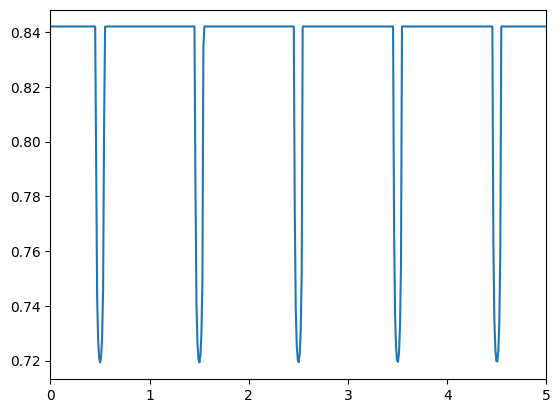

In [4]:
I0 = 1
u1 = .5
u2 = 0.5
Ncakes = 1000
t0 = 0.5
T = 0.1
k = 0.2
P = 1.0

t = np.linspace(0, 10, 1000)

ld_transit = np.zeros_like(t)

for i, ti in enumerate(t):
    ld_transit[i] = layer_cake_limb_darkening(ti, t0, b0, T, k, P, I0, u1, u2)

plt.plot(t, ld_transit)
plt.xlim([0,5])
plt.show()


In [5]:

def quadratic_limb_darkening(I0star, r, u1, u2):
    mu = np.sqrt(1 - r**2)
    return I0star * (1 - u1 * (1 - mu) - u2 * (1 - mu)**2)

def layer_cake_limb_darkening(t, t0, b0, T, k, P, I0star, u1, u2):

    N=5000
    rs = np.linspace(0, 1, N + 1)
    rm = np.mean(np.array([rs[:-1], rs[1:]]), axis=0)

    t_fold = t - np.floor(t / P) * P

    v = 2 / T * np.sqrt((1 + k)**2 - b0**2)
    b = np.sqrt(b0**2 + (v * (t_fold - t0))**2)

    diff_rm_b = (rm - b)**2
    i_rb = np.argmin(diff_rm_b)
    rb = rm[i_rb]
    transit_cake = quadratic_limb_darkening(I0star, rb, u1, u2)
    surface_brightness_transit = np.pi * (f_covered(b, k)** 2) * transit_cake
    I= I0star * (1 - u1 - u2)
    Iprev = I
    surface_brightness = I
    for i in range(1, len(rm)):
        rm_i = rm[-i]
        Icurrent = quadratic_limb_darkening(I0star, rm_i, u1, u2)
        surface_brightness_i = (Icurrent - Iprev) * rm_i
        surface_brightness += surface_brightness_i
        Iprev = Icurrent
    light_curve = surface_brightness - surface_brightness_transit
    return light_curve/surface_brightness

The period with maximum power is 9.802960494069215 d days


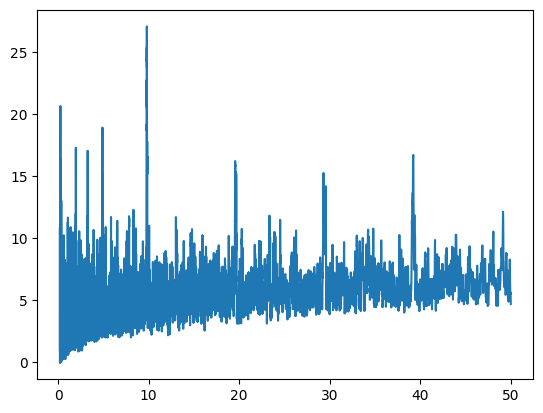

In [6]:
##problem 4

import numpy as np
import astropy.units as u
from astropy.timeseries import BoxLeastSquares

t = np.loadtxt('mystery_planet02.txt')[:, 0]
y = np.loadtxt('mystery_planet02.txt')[:, 1]
dy = np.loadtxt('mystery_planet02.txt')[:, 2]

model = BoxLeastSquares(t * u.day, y, dy=dy)

periodogram = model.autopower(0.1)
max_power = np.argmax(periodogram.power)
max_power_index = np.argmax(periodogram.power)
max_power_period = periodogram.period[max_power_index]
plt.plot(periodogram.period, periodogram.power)
print(f"The period with maximum power is {max_power_period} days")

In [7]:
def log_likelihood(params, t, RV, error):
    model = layer_cake_limb_darkening(t, *params)
    return -0.5 * np.sum((RV - model)**2 / error**2)

def log_prior(params):
    t0, b0, T, k, P, I0star, u1, u2 = params
    if 4 < t0 < 6 and 0 < b0 < 5 and 0 < T < 15 and 0 < k < 1 and 0 < P < 15 and -10 < I0star < 10 and -1 < u1 < 1 and -1 < u2 < 1:
        return 0.0
    return -np.inf


def log_probability(params, t, RV, error):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, t, RV, error)

In [8]:

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([5, 0.1, 1, 0.1, 10, 1, 0, 0 ]) + 0.1 * np.random.randn(8)
soln = minimize(nll, initial, args=(t, y, dy))
print("Best fit: ", soln.x)

Best fit:  [ 5.05138258  0.08678808  1.05565029 -0.04608916  9.98056297  0.97658629
  0.1556276   0.07499306]


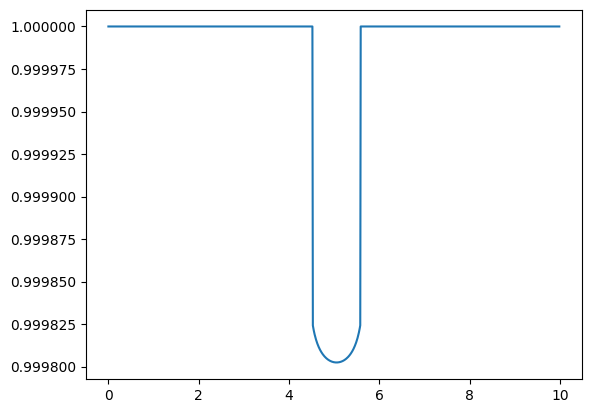

In [9]:

t_ = np.linspace(0, np.max(t%9.98), 1000)

ld_transit = np.zeros_like(t_)

for i, ti in enumerate(t_):
    ld_transit[i] = layer_cake_limb_darkening(ti, 5.04967142, 0.08617357, 1.06476885, -0.08814347, 9.97658466, 0.91075765,  0.1556276, 0.07499306)

plt.plot(t_, ld_transit)

plt.show()

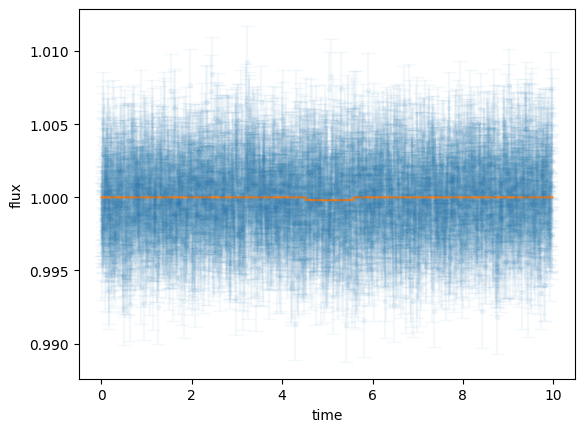

In [10]:
folded_time = t%9.98
sort_order = np.argsort(folded_time)
plt.errorbar(folded_time[sort_order], y[sort_order], yerr=dy[sort_order], fmt='.', capsize=5, alpha=0.05)
plt.plot(t_, ld_transit)
plt.xlabel('time')
plt.ylabel('flux')
plt.show()

In [11]:
def density(T, b0, P):
    v = 2 / T * np.sqrt((1 + k)**2 - b0**2)
    T_mid = 2 / v * np.sqrt(1 - b0**2)
    density= 3 / np.pi**2 * (P * u.day) / (const.G * (T * u.day)**3) * (1 - b0**2)**(3/2)
    return density.to(u.g / u.cm**3).round
print(density(1.064, 0.086,9.98 ))

<bound method Quantity.round of <Quantity 0.00499871 g / cm3>>
